# **PRUNING CHALLENGE**

## **INTRODUCTION**

The goal of this assignment is to test two method of pruning to improve the performance of model using less number of weights and neuron unit.

### **Pruning Method** :

1.  Weight Pruning
2.  Unit Pruning (Neuron Pruning)

**Our Goal in this assignment** :

1 .Construct a ReLU-activated neural network with four hidden layers with sizes [1000, 1000, 500, 200]. Note: you’ll have a fifth layer for your output logits, which you will have 10 of.
2. Train your network on MNIST or Fashion-MNIST (your choice, whatever is easier)
3. Prune away (set to zero) the k% of weights using weight and unit pruning for k in [0, 25,50, 60, 70, 80, 90, 95, 97, 99]. Remember not to prune the weights leading to the output logits.
4. Create a table or plot showing the percent sparsity (number of weights in your network that are zero) versus percent accuracy with two curves (one for weight pruning and one for unit pruning).
5. Make the code clean and readable. Add comments where needed. 

### SUBMISSION

Please email a zip file with the following contents:
1. Your Jupyter Notebook
2. A word document with the results you observed. What interesting insights did you find? Do the curves differ? Why do you think that is/isn’t? Do you have any hypotheses as to why we are able to delete so much of the network without hurting performance (this is an open research question)? Write a description of roughly 200 words.
3. Include the following header in the results word document mentioned above:
Name:
College/graduating year/GPA:
Phone number:
Email ID:
4. Name of the ZIP file should be firstname_collegename.zip. For instance, if my name is John and I’m from IIT Bombay then the submission file should be called john_iitbombay.zip

#### **To complete the assignment I have used CPU because dataset was not so much large, So i am able to run the whole dataset in CPU only.**
#### **I have used MNIST Dataset to perform pruning.**

In [0]:
USE_GPU = False
DATASET = 'mnist' # must be one of ('mnist', 'fashion-mnist')
NUM_EPOCHS = 10   # NUM_EPOCHS specify the number of times you want to train the model
BATCH_SIZE = 64   # BATCH_SIZE defines the size of input data in one run
PRUNING_PERCENTAGES = [0, 25, 50, 60, 70, 80, 90, 95, 97, 99]  # PRUNING_PERCENTAGES will tells that how much percentage of weights or neuron you need to skip or make 0.

### **LIBRARIES USED**

In [2]:
# from __future__ import annotations

from typing import List, Callable, Mapping, Tuple

import os
import time
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tqdm import tqdm
from numpy import linalg as LA

### **DATASET**

In [0]:
def get_dataset(dataset_name):
    """Function is used to get the dataset of MNIST or FASHION MNIST
    
    Args:
        dataset_name: Name of a dataset. Must be one of (`mnist`, `fashion-mnist`)
        
    Returns:
        dict: dict contains following entries:
            dict['shape'] (Tuple[int, int]) - shape of the images in the dataset,
            dict['train'] (tf.data.Dataset) - train dataset,
            dict['train'] (tf.data.Dataset) - test dataset.
    """
    dataset = {
        'mnist': tf.keras.datasets.mnist,
        'fashion-mnist': tf.keras.datasets.fashion_mnist
    }

    (train_images, train_labels), (test_images, test_labels) = dataset[dataset_name].load_data()
    train_images, test_images = (train_images / 255).astype(np.float32), (test_images / 255).astype(np.float32)
    train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).batch(BATCH_SIZE)  # code will divide input data into unit of BATCH SIZE
    test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).batch(BATCH_SIZE)
    return {
        'shape': train_images.shape[1:],
        'train': train_dataset,
        'test': test_dataset
    }

### **DENSE MODEL**
##### Simple MLP network with 4 hidden layers with 1000, 1000, 500 and 200 neurons respectively. Every hidden layer uses relu activation function. Model returns ouput for 10 classes after softmax.

In [0]:
def get_dense_model(input_shape, hidden_sizes = [1000, 1000, 500, 200]):
    """Function is used to create the BASE MODEL
    
    Args:
        input_shape (Tuple[int, int]): Dimensions of an input image.
        
    Returns:
         Model:  MLP network with 4 hidden layers with 1000, 1000, 500 and 200 neurons respectively.
    """
    dense_model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=input_shape),
        *[tf.keras.layers.Dense(hidden_size, activation='relu', use_bias=False, kernel_initializer = tf.keras.initializers.he_normal(seed=None)) for hidden_size in hidden_sizes],
        tf.keras.layers.Dense(10, activation='softmax', use_bias=False),
    ])

    dense_model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
    )
    return dense_model

### **TRANING THE MODEL**

In [67]:

dataset = get_dataset(DATASET)  # get the data
dense_model = get_dense_model(dataset['shape']) # create a model

# this code is used to train the model on data
dense_model.fit(
    dataset['train'],
    epochs=NUM_EPOCHS
)

# get the weights of the model
original_weights = dense_model.get_weights()

# test the trained model on test data and got the loss and accuracy
loss, acc = dense_model.evaluate(dataset['test'], verbose=False)
print("Loss: {loss}, Accuracy: {acc}")

Train on 938 steps
Epoch 1/10
938/938 [==============================] - 17s 18ms/step - loss: 0.2157 - sparse_categorical_accuracy: 0.9347
Epoch 2/10
938/938 [==============================] - 17s 18ms/step - loss: 0.0951 - sparse_categorical_accuracy: 0.9721
Epoch 3/10
938/938 [==============================] - 17s 18ms/step - loss: 0.0675 - sparse_categorical_accuracy: 0.9798
Epoch 4/10
938/938 [==============================] - 17s 18ms/step - loss: 0.0547 - sparse_categorical_accuracy: 0.9832
Epoch 5/10
938/938 [==============================] - 17s 18ms/step - loss: 0.0469 - sparse_categorical_accuracy: 0.9864
Epoch 6/10
938/938 [==============================] - 17s 18ms/step - loss: 0.0346 - sparse_categorical_accuracy: 0.9896
Epoch 7/10
938/938 [==============================] - 17s 18ms/step - loss: 0.0317 - sparse_categorical_accuracy: 0.9906
Epoch 8/10
938/938 [==============================] - 16s 18ms/step - loss: 0.0283 - sparse_categorical_accuracy: 0.9911
Epoch 9/10
93

In [68]:
# Copy the weights to another variable for further use
weights_copy1 = dense_model.get_weights()[:]
weights_copy2 = weights_copy1[:]
original_weights = weights_copy[:]
print(hex(id(weights_copy1)), hex(id(weights_copy2)))
print(weights_copy1)

0x7fb7535a52c8 0x7fb7535a5388
[array([[ 0.02360198,  0.06782135, -0.0653123 , ...,  0.02413504,
         0.02080449, -0.055004  ],
       [ 0.0382887 , -0.06574985, -0.08584944, ..., -0.01029761,
         0.08780684,  0.00215984],
       [-0.00433097, -0.03110573, -0.10915792, ...,  0.07474329,
         0.04763312, -0.00640799],
       ...,
       [-0.03067203,  0.00474661,  0.0280134 , ...,  0.00521061,
        -0.09566346,  0.04101371],
       [-0.07465428, -0.05510021, -0.03457761, ..., -0.10573369,
        -0.11289019,  0.01157712],
       [-0.04663521,  0.01092986,  0.01004729, ...,  0.01621566,
        -0.08430255,  0.01698193]], dtype=float32), array([[ 2.9650182e-02,  5.1070001e-02, -9.8647192e-02, ...,
         5.5224203e-02,  4.1545838e-02, -3.4427665e-02],
       [ 7.4229039e-02,  9.8447278e-02, -2.8017776e-02, ...,
         1.4061069e-01, -1.4491164e-02, -9.0329491e-02],
       [-4.6449881e-02,  7.4491315e-02,  4.5851994e-02, ...,
        -8.4625639e-02, -6.8709567e-02, -2.

 ### **SPARSE MODE**

**1. for weight model i have used weight_pruning function inside pruining class**

In [0]:
class pruning:

  ''' class pruning is use to get sparse weight for weight pruning and store accuracy, loss and time data in dictionary to further use for comparision'''

    def __init__(self, original_weights):
      # initialize the metrics dictionary, this is generally a dictionary of lists
        self.metrics = defaultdict(list)
        self.sparse_model = None
        self.original_weights = original_weights
    def weight_pruning(self, perc):
      ''' Function will return weights for a model after applying perc of weight pruning
      
      Args:
        input_shape (int]): percentage of pruning
        
    Returns:
         Weights for the model after pruning
      '''

        weights = []
        # print(type(weights))
        for index in range(0,len(self.original_weights)-1):
          # here we have not used the last layer output because we will not prune the final weight matrix leading to the logits.
            weights_shape = self.original_weights[index].shape  # getting the shape of input data for reshapping ahead
            weights1 = np.ndarray.flatten(np.asarray(self.original_weights[index]))  # converting the input data to flat data for comparision
            weights1[np.abs(weights1)<np.percentile(np.abs(weights1),perc)] = 0
            weights1 = weights1.reshape(weights_shape)
            weights.append(weights1)
        weights.append(self.original_weights[len(self.original_weights)-1])
        return weights

    def copy_dense_model(self, dense_model):
      # copy dense model to other variable for further use
        self.sparse_model = dense_model
        return self.sparse_model

    def metric_add(self, loss, acc, time, type):
      # function is use to store the loss, accuracy and time value in the dictionary
        self.metrics['pruning_loss_'+type].append(loss)
        self.metrics['pruning_acc_'+type].append(acc)
        self.metrics['pruning_time_'+type].append(time)

**2. for neuron pruning i have used neuron_pruning function**

In [0]:
def neuron_pruning(perc):
  ''' Function will return weights for a model after applying perc of neuron pruning
      
      Args:
        input_shape (int]): percentage of pruning
        
    Returns:
         Weights for the model after pruning
      '''

    weights = []
    for index in range(0,len(weights_copy1)-1):
        weight1 = np.asarray(weights_copy1[index])
        norm1 = LA.norm(weight1, axis=0)
        # below code is use to make weight value equal to zero if weight value is less than perc percentile value
        weight1[:,np.argwhere(norm1<np.percentile(norm1,perc))] = 0
        weights.append(weight1)
    weights.append(weights_copy1[len(weights_copy1)-1])
    return weights

In [78]:
prune_class = pruning(original_weights[:])
for perc in tqdm(PRUNING_PERCENTAGES):
  # loop will run for each pruning percentage
    prune_class.metrics['pruning_percentage'].append(perc)

  # Dense Model
    dense_model.set_weights(original_weights)
    # dense model will give loss , acc value for the dataset
    start = time.process_time()
    loss, acc = dense_model.evaluate(dataset['test'], verbose=False)
    start = time.process_time() - start
    prune_class.metric_add(loss, acc, start, "dense")

  # Weight Model
    weight_sparse_model = prune_class.copy_dense_model(dense_model)
    weight_sparse_model.set_weights(prune_class.weight_pruning(perc))
    # print("weight : ",weight_sparse_model.get_weights())
    start = time.process_time()
    loss, acc = weight_sparse_model.evaluate(dataset['test'], verbose=False)
    start = time.process_time() - start
    prune_class.metric_add(loss, acc, start, "weight_sparse")

  # Neuron Model
    neuron_sparse_model = prune_class.copy_dense_model(dense_model)
    neuron_sparse_model.set_weights(neuron_pruning(perc))
    # print("neuron : ",weight_sparse_model.get_weights())
    start = time.process_time()
    loss, acc = neuron_sparse_model.evaluate(dataset['test'], verbose=False)
    start = time.process_time() - start
    prune_class.metric_add(loss, acc, start, "neuron_sparse")



  # weights = prune_class.weight_pruning(perc)

100%|██████████| 10/10 [00:48<00:00,  4.84s/it]


### **PLOTS**

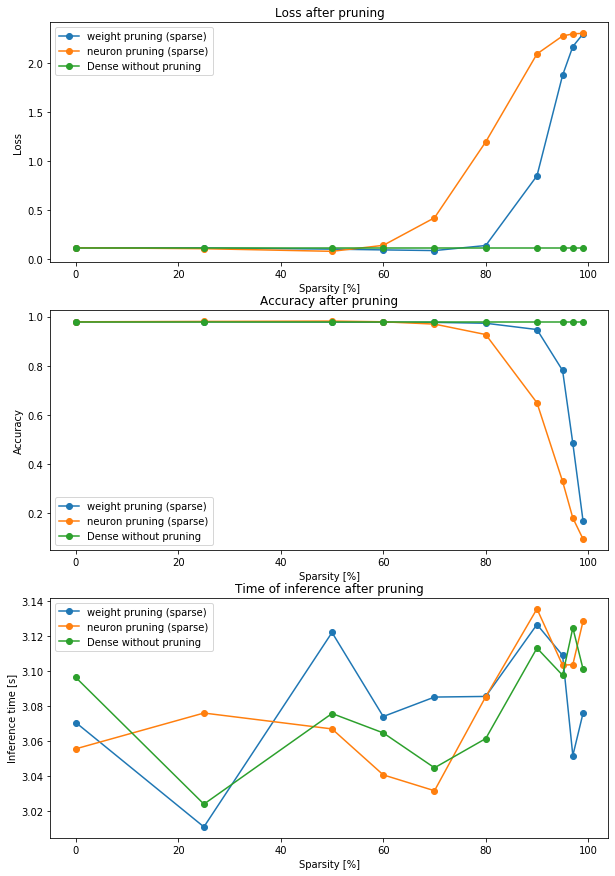

In [79]:
# Plotting the graph to compare the loss, accuracy and time of each model : dense, weighted and nuron pruned model.

fig, ax = plt.subplots(3, figsize=(10,15))


# Loss data
ax[0].plot(prune_class.metrics['pruning_percentage'], prune_class.metrics['pruning_loss_weight_sparse'], 'o-', label='weight pruning (sparse)')
ax[0].plot(prune_class.metrics['pruning_percentage'], prune_class.metrics['pruning_loss_neuron_sparse'], 'o-', label='neuron pruning (sparse)')
ax[0].plot(prune_class.metrics['pruning_percentage'], prune_class.metrics['pruning_loss_dense'], 'o-', label='Dense without pruning')
ax[0].set_title('Loss after pruning')
ax[0].set_xlabel('Sparsity [%]')
ax[0].set_ylabel('Loss')
ax[0].legend()


# Accuracy Data
ax[1].plot(prune_class.metrics['pruning_percentage'], prune_class.metrics['pruning_acc_weight_sparse'], 'o-', label='weight pruning (sparse)')
ax[1].plot(prune_class.metrics['pruning_percentage'], prune_class.metrics['pruning_acc_neuron_sparse'], 'o-', label='neuron pruning (sparse)')
ax[1].plot(prune_class.metrics['pruning_percentage'], prune_class.metrics['pruning_acc_dense'], 'o-', label='Dense without pruning')
ax[1].set_title('Accuracy after pruning')
ax[1].set_xlabel('Sparsity [%]')
ax[1].set_ylabel('Accuracy')
ax[1].legend()


# Time of each model
ax[2].plot(prune_class.metrics['pruning_percentage'], prune_class.metrics['pruning_time_weight_sparse'], 'o-', label='weight pruning (sparse)')
ax[2].plot(prune_class.metrics['pruning_percentage'], prune_class.metrics['pruning_time_neuron_sparse'], 'o-', label='neuron pruning (sparse)')
ax[2].plot(prune_class.metrics['pruning_percentage'], prune_class.metrics['pruning_time_dense'], 'o-', label='Dense without pruning')
# ax[2].plot(metrics['pruning_percentage'], metrics['weight_dense_dt'], 'o-', label='weight pruning (dense)')
ax[2].set_title('Time of inference after pruning')
ax[2].set_xlabel('Sparsity [%]')
ax[2].set_ylabel('Inference time [s]')
ax[2].legend()

plt.show()

### **CONCLUSION**

From the loss and accuracy plot we can see that for weight pruning till 80% sparcity we are getting same loss and accuracy, So we can say 80 percentage of weights in our dense model are not useful to give same performance. They are just using space of disk and RAM.

But for neuron pruning loss increases after 60 percentage of sparcity and accuracy start decreasing after 70 percentage of sparcity. 

After 80 percentage weight model performance is reduceing.
Accuracy for weight pruning is reducing, because after 80% sparcity we are making imp weight to zero, and for neuron pruning we can say imp neuron are deleted.

 **But the Question here is why weight pruning is more effective here?**

This may be because we are not removing the neurons in weight pruning, so some neurons may giving some amount of information for predicting right value and also in weight pruning we are making some weight value zero, so there may be possibility that some zero value weights are exchanging some useful information for predicting right class.

 **Neuron pruning** -: 
Neuron pruning is giving good peformance upto sparcity = 70 percentage. This may be because till sparcity our neuron is exchanging some useful information with the input data, which is useful for classificaton. But after 70% there may be possibility that our model got underfitting, which is predicting wrong output in train and test time.


## **RETRAIN NEURON NETWORK**

### **For futher analysis, i have tried to retrain the each sparcity value till 10 EPOCH size for neuron pruning.**

In [93]:
for perc in tqdm(PRUNING_PERCENTAGES):
    small_model = get_dense_model(dataset['shape'], hidden_sizes=(np.array([1000, 1000, 500, 200]) * ((100 - perc) / 100)).astype(np.int))
    small_model.fit(
        dataset['train'],
        epochs=NUM_EPOCHS,
        verbose=False
    )
    start = time.process_time()
    loss, acc = small_model.evaluate(dataset['test'], verbose=False)
    start = time.process_time() - start
    prune_class.metric_add(loss, acc, start, "small_weight")



  0%|          | 0/10 [00:00<?, ?it/s]



 10%|█         | 1/10 [02:44<24:44, 164.96s/it]



 20%|██        | 2/10 [04:38<19:57, 149.65s/it]



 30%|███       | 3/10 [06:02<15:09, 129.96s/it]



 40%|████      | 4/10 [07:09<11:05, 110.97s/it]



 50%|█████     | 5/10 [08:03<07:49, 93.96s/it] 



 60%|██████    | 6/10 [08:53<05:22, 80.62s/it]



 70%|███████   | 7/10 [09:35<03:27, 69.10s/it]



 80%|████████  | 8/10 [10:08<01:56, 58.20s/it]



 90%|█████████ | 9/10 [10:34<00:48, 48.60s/it]



100%|██████████| 10/10 [11:00<00:00, 41.68s/it]



In [0]:
# prune_class.metrics

### **PLOT**

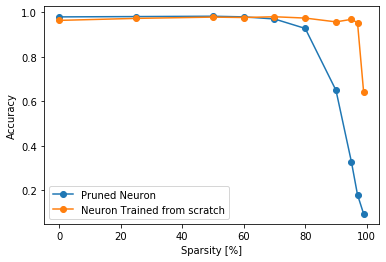

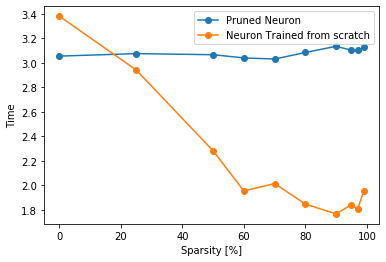

In [96]:
plt.plot(prune_class.metrics['pruning_percentage'], prune_class.metrics['pruning_acc_neuron_sparse'], 'o-', label='Pruned Neuron')
plt.plot(prune_class.metrics['pruning_percentage'], prune_class.metrics['pruning_acc_small_weight'], 'o-', label='Neuron Trained from scratch')
plt.xlabel('Sparsity [%]')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(prune_class.metrics['pruning_percentage'], prune_class.metrics['pruning_time_neuron_sparse'], 'o-', label='Pruned Neuron')
plt.plot(prune_class.metrics['pruning_percentage'], prune_class.metrics['pruning_time_small_weight'], 'o-', label='Neuron Trained from scratch')
plt.xlabel('Sparsity [%]')
plt.ylabel('Time')
plt.legend()
plt.show()

#### 1. From the plot we can see that accuracy of the network improves for the sparcity value between 80 to 90 as compare normal sparse neuron pruned network.
#### 2. Time taken to evaluate the test data also decreases in retrained model after 20 percentage of sparcity value. 

### ** ***LIKE THIS WE CAN ALSO RETRAIN WEIGHT PRUNING NETWORK.***   **
